In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import mlflow

Processed data from demo-02 is loaded

In [0]:
X_train = pd.read_csv('/dbfs/FileStore/datasets/processed_x_train.csv')
X_test = pd.read_csv('/dbfs/FileStore/datasets/processed_x_test.csv')
y_train = pd.read_csv('/dbfs/FileStore/datasets/processed_y_train.csv')
y_test = pd.read_csv('/dbfs/FileStore/datasets/processed_y_test.csv')

In [0]:
X_train.head()

,cat__fuel_Diesel,cat__fuel_LPG,cat__fuel_Petrol,cat__seller_type_Individual,cat__seller_type_Trustmark Dealer,cat__transmission_Manual,cat__owner_Fourth & Above Owner,cat__owner_Second Owner,cat__owner_Test Drive Car,cat__owner_Third Owner,remainder__km_driven,remainder__seats,remainder__Age,remainder__mileage,remainder__engine,remainder__max_power
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.484513,1.609196,-0.610529,-0.771136,0.128951,-0.558481
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.055758,-0.440923,0.418569,0.710215,0.309462,1.201661
2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.274135,-0.440923,-0.610529,1.214180,-0.367962,0.019691
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.271679,-0.440923,0.161294,-0.396980,0.139092,0.366594
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.271679,-0.440923,-0.095980,1.700328,-0.367962,0.019691


In [0]:
y_train.head()

,selling_price
0,700000
1,500000
2,919999
3,350000
4,560000


In [0]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

Out[5]: ((5361, 16), (1341, 16), (5361, 1), (1341, 1))

In [0]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

y_train = min_max_scaler.fit_transform(y_train.values.reshape(-1, 1))

y_test = min_max_scaler.transform(y_test.values.reshape(-1, 1))

y_train

Out[6]: array([[0.0672017 ],
       [0.04714152],
       [0.08926779],
       ...,
       [0.32296897],
       [0.01404223],
       [0.00300913]])

Neural network is defined

In [0]:
def nn_model(n):
    model = Sequential()
    
    model.add(Dense(int(n['dense_l1']), input_dim = 16, activation = 'relu'))
    model.add(Dense(int(n['dense_l2']), activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    return model

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, SparkTrials
    
def runNN(n):
    import tensorflow as tf
    
    mlflow.tensorflow.autolog()
    
    with mlflow.start_run(nested = True):
        model = nn_model(n)

        optimizer_call = getattr(tf.keras.optimizers, n['optimizer'])
        optimizer = optimizer_call(learning_rate = n['learning_rate'])

        model.compile(loss = 'mse',
                    optimizer = optimizer,
                    metrics = ['mse'])
        history = model.fit(X_train, y_train, validation_split = .2, epochs = 10, verbose = 2)

        score = model.evaluate(X_test, y_test, verbose = 0)
        obj_metric = score[0]
        mlflow.log_metric('test_mse',  obj_metric)

        y_pred = model.predict(X_test)
        rsquare_score = r2_score(y_test, y_pred)
        mlflow.log_metric('rsquare_score', rsquare_score)

        return {'loss': obj_metric, 'status': STATUS_OK}

Search space for hyperparameters is defined

In [0]:
space = {
  'dense_l1': hp.quniform('dense_l1', 16, 32, 8),
  'dense_l2': hp.quniform('dense_l2', 16, 32, 8),
  'learning_rate': hp.loguniform('learning_rate', -5, 0),
  'optimizer': hp.choice('optimizer', ['Adadelta', 'Adam'])
 }

In [0]:
spark_trials = SparkTrials()

Because the requested parallelism was None or a non-positive value, parallelism will be set to (4), which is Spark's default parallelism (4), or 1, whichever is greater. We recommend setting parallelism explicitly to a positive value because the total of Spark task slots is subject to cluster sizing.


Best set of hyperparameters can be found out using following code with corresponding loggings of parameters and metrics

In [0]:
with mlflow.start_run():
    best_hyperparam = fmin(fn = runNN, 
                         space = space, 
                         algo = tpe.suggest, 
                         max_evals = 32, 
                         trials = spark_trials)

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.
100%|██████████| 32/32 [02:08<00:00,  4.02s/trial, best loss: 0.00034071688423864543]
Total Trials: 32: 32 succeeded, 0 failed, 0 cancelled.


##### TODO Recording
- After running the code above, stay on this page and watch as more runs are added to the same experiment
- Click on "experiment" and that will open up the Experiment on a new tab
- There should be 33 runs in the Experiment
- Expand the parent run
- Sort by R2 and find the run with the highest R2 score
- Click on that run and expand the "Parameters" and "Metrics" tab and show
- Go to artifacts and show the model summary

Best set of hyperparameters are obtained

In [0]:
import hyperopt
 
print(hyperopt.space_eval(space, best_hyperparam))

{'dense_l1': 24.0, 'dense_l2': 32.0, 'learning_rate': 0.007264255525662456, 'optimizer': 'Adam'}


Neural network parameters are defined using best set of hyperparameters

In [0]:
best_param = hyperopt.space_eval(space, best_hyperparam)

first_layer = best_param['dense_l1']
second_layer = best_param['dense_l2']
learning_rate = best_param['learning_rate']
optimizer = best_param['optimizer']

optimizer_call = getattr(tf.keras.optimizers, optimizer)
optimizer = optimizer_call(learning_rate = learning_rate)

In [0]:
def best_nn_model():
    model = Sequential()

    model.add(Dense(first_layer, input_dim = 16, activation = 'relu'))
    model.add(Dense(second_layer, activation = 'relu'))
    model.add(Dense(1, activation = 'linear'))
    
    return model

In [0]:
best_model = best_nn_model()
  
best_model.compile(loss = 'mse',
                   optimizer = optimizer,
                   metrics = ['mse'])

ReTraining and logging all parameters using best set of hyperparameters

Epoch 1/35
168/168 [==============================] - 1s 1ms/step - loss: 0.0108 - mse: 0.0108
Epoch 2/35
168/168 [==============================] - 0s 977us/step - loss: 0.0025 - mse: 0.0025
Epoch 3/35
168/168 [==============================] - 0s 1ms/step - loss: 9.1882e-04 - mse: 9.1882e-04
Epoch 4/35
168/168 [==============================] - 0s 1ms/step - loss: 4.5227e-04 - mse: 4.5227e-04
Epoch 5/35
168/168 [==============================] - 0s 2ms/step - loss: 4.2443e-04 - mse: 4.2443e-04
Epoch 6/35
168/168 [==============================] - 0s 984us/step - loss: 4.1880e-04 - mse: 4.1880e-04
Epoch 7/35
168/168 [==============================] - 0s 1ms/step - loss: 4.2643e-04 - mse: 4.2643e-04
Epoch 8/35
168/168 [==============================] - 0s 989us/step - loss: 4.3286e-04 - mse: 4.3286e-04
Epoch 9/35
168/168 [==============================] - 0s 998us/step - loss: 4.1287e-04 - mse: 4.1287e-04
Epoch 10/35
168/168 [==============================] - 0s 2ms/step - loss: 3.7708

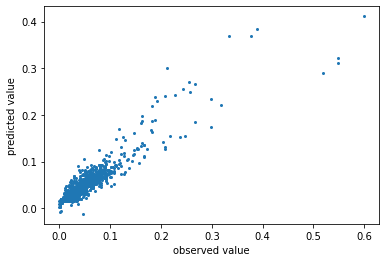

In [0]:
mlflow.tensorflow.autolog()
 
with mlflow.start_run() as run:

    early_stopping = EarlyStopping(monitor = 'loss', mode = 'min', patience = 3)
    history = best_model.fit(X_train, y_train, epochs = 35, callbacks = [early_stopping])
    
    kerasURI = run.info.artifact_uri
    
    mlflow.log_metric('eval_result', new_model.evaluate(X_test, y_test)[0])
    
    keras_pred = best_model.predict(X_test)
    
    rsquare_score = r2_score(y_test, keras_pred)
    mlflow.log_metric('rsquare_score', rsquare_score)
    
    plt.plot(y_test, keras_pred, 'o', markersize = 2)
    plt.xlabel('observed value')
    plt.ylabel('predicted value')
    plt.savefig('kplot.png')

    mlflow.log_artifact('kplot.png') 

#### TODO Recording

- Click on "1 run" and open up the run
- Open up "Metrics" and show
- Under artifacts show the plot that has been saved

Model is registered

In [0]:
model_name = 'car_price_prediction_opt_model'
model_uri = kerasURI + '/model'

new_model_version = mlflow.register_model(model_uri, model_name)

Successfully registered model 'car_price_prediction_opt_model'.
2022/11/09 14:13:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: car_price_prediction_opt_model, version 1
Created version '1' of model 'car_price_prediction_opt_model'.


Prediction on test data is done using the registered model

In [0]:
keras_model = mlflow.keras.load_model(f'models:/{model_name}/{new_model_version.version}')
 
predicions = keras_model.predict(X_test)
predicions 

42/42 [==============================] - 0s 729us/step
Out[32]: array([[0.1014407 ],
       [0.01474954],
       [0.00921741],
       ...,
       [0.02852596],
       [0.08830798],
       [0.01153316]], dtype=float32)